<a href="https://colab.research.google.com/github/R3gm/InsightSolver-Colab/blob/main/Latent_Consistency_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Latent Consistency Models: Synthesizing High-Resolution Images with Few-step Inference

LCMs build upon the concept of Consistency Models (CMs) which enable faster sampling while maintaining high generation quality. The core idea of CMs is to learn a function that maps points on a trajectory of the Probability Flow ODE (PF-ODE) to the origin of that trajectory.

`This is a showcase of LCM with diffusers.`

| Code Credits | Link |
| ----------- | ---- |
| 🎉 Original Repository | [![GitHub Repository](https://img.shields.io/github/stars/luosiallen/latent-consistency-model?style=social)](https://github.com/luosiallen/latent-consistency-model) |
| 🚀 Online inference | [![Replicate](https://replicate.com/google-research/frame-interpolation/badge)](https://replicate.com/luosiallen/latent-consistency-model)
| 🔥 Discover More Colab Notebooks | [![GitHub Repository](https://img.shields.io/badge/GitHub-Repository-black?style=flat-square&logo=github)](https://github.com/R3gm/InsightSolver-Colab/) |


In [ ]:
!pip install git+https://github.com/huggingface/diffusers.git transformers==4.34.1 accelerate==0.24.0 compel==2.0.2 moviepy
!pip install xformers==0.0.22.post4 --index-url https://download.pytorch.org/whl/cu118

The pipeline defaults to using LCMScheduler. LCM models are different from the typical Stable Diffusion models, so they cannot be used in the same way in several aspects.

## LCM text to image

In [ ]:
from diffusers import DiffusionPipeline, LatentConsistencyModelPipeline, AutoencoderTiny
from compel import Compel, ReturnedEmbeddingsType
from IPython.display import display
import torch, random, time
from diffusers.schedulers import LCMScheduler

pipe = DiffusionPipeline.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    safety_checker=None,
    custom_pipeline="latent_consistency_txt2img",
    # scheduler = LCMScheduler(
    #             beta_start=0.00085,
    #             beta_end=0.0120,
    #             beta_schedule="scaled_linear",
    #             prediction_type="epsilon",
    #         ),
    custom_revision="main",
    cache_dir = "./cache"
)

In [ ]:
# Optimizations: tiny vae, float16, xformers attention
pipe.vae = AutoencoderTiny.from_pretrained(
    "madebyollin/taesd", torch_dtype=torch.float16, use_safetensors=True
)
pipe.to(torch_device="cuda", torch_dtype=torch.float16)
pipe.enable_xformers_memory_efficient_attention()

LCM does not have negative prompt at the moment. To improve the responses, it may be helpful for us to use compel to emphasize parts of the prompt.

In [ ]:
create_embeds = Compel(
    tokenizer=pipe.tokenizer,
    text_encoder=pipe.text_encoder,
    truncate_long_prompts=False,
    #returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NORMALIZED # clip_skip PENULTIMATE layer
)

Parameters

In [ ]:
prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"
num_inference_steps = 8
width= 512
height= 512
guidance_scale = 8.0
num_images = 4

Inference txt2img

  0%|          | 0/8 [00:00<?, ?it/s]

Execution time: 2.2384872436523438 seconds


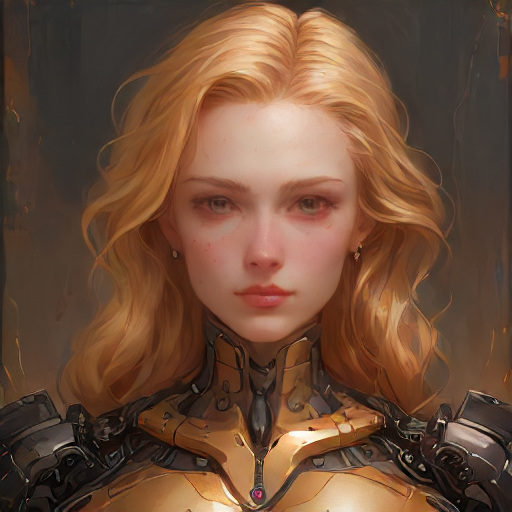

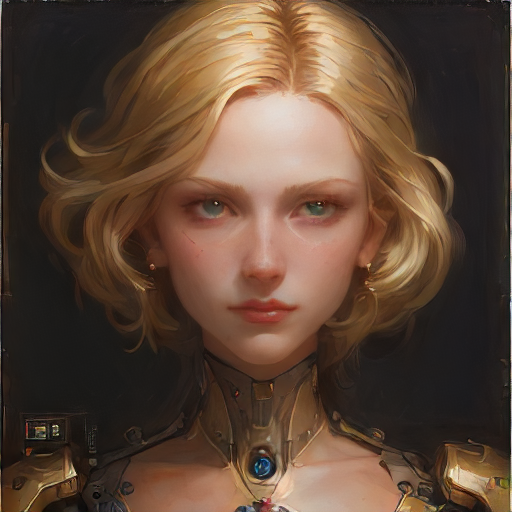

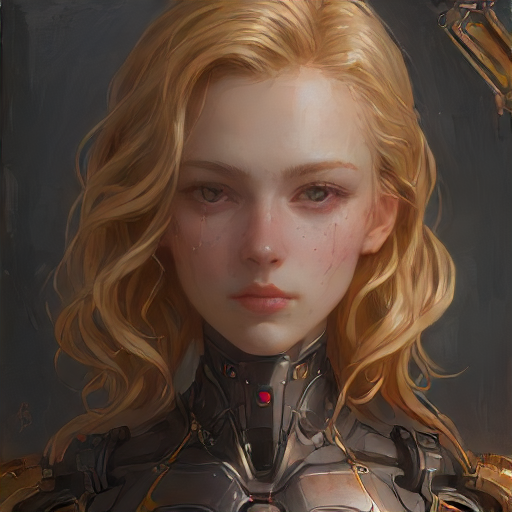

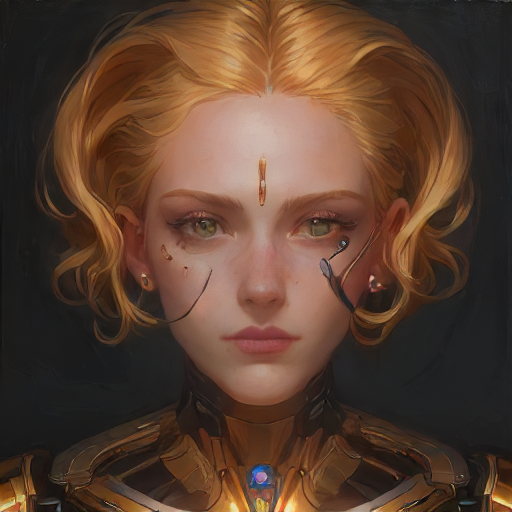

In [ ]:
start_time = time.time()

images = pipe(
    prompt_embeds = create_embeds(prompt),
    width=width,
    height=height,
    num_images_per_prompt=num_images,
    num_inference_steps=num_inference_steps,
    guidance_scale=guidance_scale,
    lcm_origin_steps=50,
    output_type="pil",
).images

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

for img in images:
    display(img)

## LCM image to image

In [ ]:
pipe_i2i = DiffusionPipeline.from_pretrained(
    "SimianLuo/LCM_Dreamshaper_v7",
    safety_checker = None,
    custom_pipeline = "latent_consistency_img2img",
    custom_revision = "main",
    cache_dir = "./cache"
)

pipe_i2i.to(torch_device="cuda", torch_dtype=torch.float16)
pipe_i2i.enable_xformers_memory_efficient_attention()

We downloaded an image and changed its resolution to 512x512.

In this step, we could also increase the resolution so that when we perform the inference with LCM and low strength value, it acts as an upscaler.

--2023-11-01 23:00:54--  https://cdn.pixabay.com/photo/2021/02/27/15/44/portrait-6054910_1280.jpg
Resolving cdn.pixabay.com (cdn.pixabay.com)... 104.18.40.96, 172.64.147.160, 2606:4700:4400::6812:2860, ...
Connecting to cdn.pixabay.com (cdn.pixabay.com)|104.18.40.96|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 237644 (232K) [binary/octet-stream]
Saving to: ‘image.png’

image.png           100%[===================>] 232.07K  --.-KB/s    in 0.09s   

2023-11-01 23:00:54 (2.57 MB/s) - ‘image.png’ saved [237644/237644]



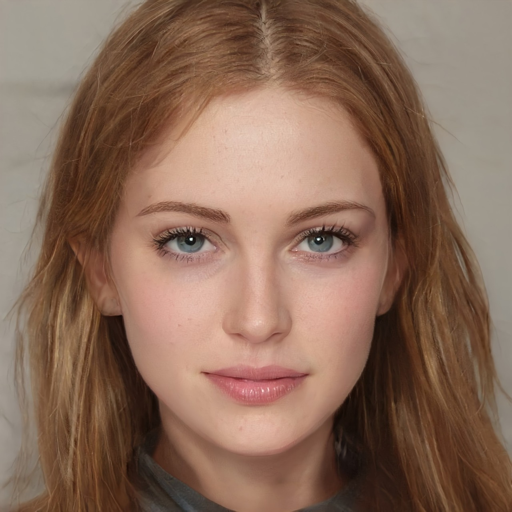

In [ ]:
from PIL import Image
!wget https://cdn.pixabay.com/photo/2021/02/27/15/44/portrait-6054910_1280.jpg -O image.png

input_image = Image.open("/content/image.png")
input_image = input_image.resize((512, 512))
input_image

In [ ]:
prompt = "Self-portrait oil painting, a beautiful cyborg with golden hair, 8k"
num_inference_steps = 3
guidance_scale = 8.0
num_images = 1
strength = 0.4

width, height = input_image.size

Inference img2img

timesteps:  tensor([399, 279, 159])


  0%|          | 0/3 [00:00<?, ?it/s]

Execution time: 0.9356935024261475 seconds


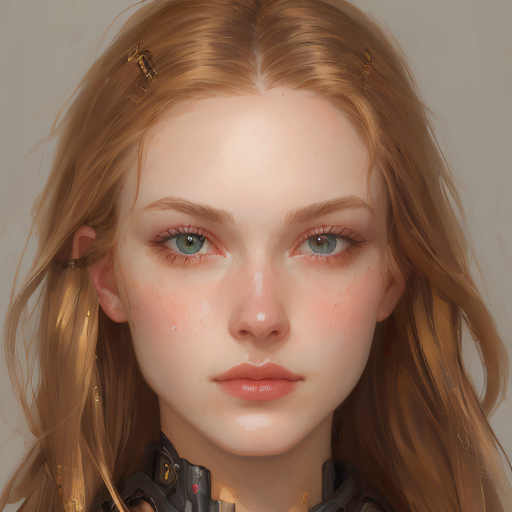

In [ ]:
start_time = time.time()

images = pipe_i2i(
    prompt_embeds = create_embeds(prompt),
    image = input_image,
    strength = strength,
    width = width,
    height = height,
    guidance_scale = guidance_scale,
    num_inference_steps = num_inference_steps,
    num_images_per_prompt = num_images,
    lcm_origin_steps = 50,
    output_type = "pil",
).images

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

for img in images:
    display(img)

In [ ]:
# Alternative custom pipeline make by radames, 30% more fast in img2img

# !wget https://huggingface.co/spaces/radames/Real-Time-Latent-Consistency-Model/resolve/main/latent_consistency_img2img.py

# custom_pipeline = "latent_consistency_img2img.py", # in pipe

# pipe.vae = AutoencoderTiny.from_pretrained(
#     "madebyollin/taesd", torch_dtype=torch.float16, use_safetensors=True
# )

## Real-Time Inference text to image


Due to the rapid inference time, we can make changes almost in real time with different parameters. Here, we will use only the prompt for illustrative purposes.

Text(value='', description='Prompt:')

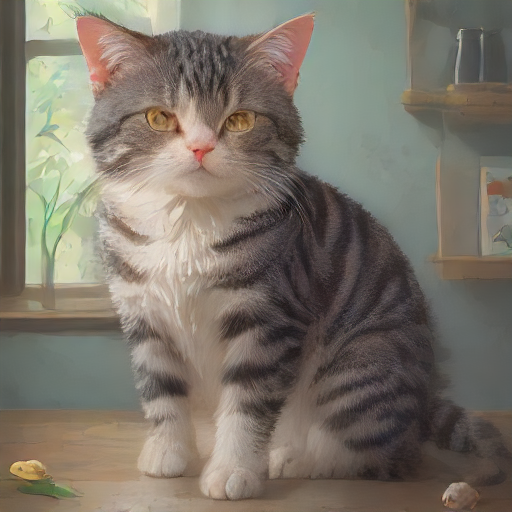

In [ ]:
import ipywidgets as widgets
from IPython.display import display
import time


preview_handle = None
prompt_b = ""
pipe.set_progress_bar_config(disable=True)

def continuous_printing(prompt):
    # print(f"Input: {change['new']}")
    global preview_handle
    global prompt_b
    if prompt_b != prompt['new']:
        image = pipe(
            prompt_embeds = create_embeds(prompt['new']),
            width=width,
            height=height,
            num_images_per_prompt=1,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            lcm_origin_steps=50,
            output_type="pil",
        ).images

        if preview_handle == None:
            preview_handle = display(image[0], display_id=True)
        else:
            preview_handle.update(image[0])

    prompt_b = prompt['new']
    time.sleep(0.01)

text = widgets.Text(
    value='',
    description='Prompt:',
    disabled=False
)

display(text)

text.observe(continuous_printing, names='value')

The image updates as the prompt is changed

## LCM video to video

In [ ]:
# Utility functions by https://github.com/0xbitches/sd-webui-lcm
import cv2
from PIL import Image
import numpy as np

def video_to_frames(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    # Check if the video opened successfully
    if not cap.isOpened():
        print("Error: LCM Could not open video.")
        return

    # Read frames from the video
    pil_images = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Convert BGR to RGB (OpenCV uses BGR by default)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert numpy array to PIL Image
        pil_image = Image.fromarray(rgb_frame)

        # Append the PIL Image to the list
        pil_images.append(pil_image)

    # Release the video capture object
    cap.release()

    return pil_images

def frames_to_video(pil_images, output_path, fps):
    if not pil_images:
        print("Error: No images to convert.")
        return

    img_array = []
    for pil_image in pil_images:
        img_array.append(np.array(pil_image))

    height, width, layers = img_array[0].shape
    size = (width, height)

    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)
    for i in range(len(img_array)):
        out.write(cv2.cvtColor(img_array[i], cv2.COLOR_RGB2BGR))
    out.release()

We will use a short 6-second video, which we will convert to frames in memory. If we use very long videos, we may encounter memory issues. In such cases, it would be better to save the frames to disk and open them iteratively for inference.

In [ ]:
!wget https://huggingface.co/spaces/VIPLab/Track-Anything/resolve/main/test_sample/test-sample2.mp4

video = "test-sample2.mp4"

frames = video_to_frames(video)

Parameters

In [ ]:
prompt = "(a dog)1.1, masterpiece+, 8k"
num_inference_steps = 3
guidance_scale = 8.0
num_images = 1
strength = 0.35
width, height = frames[0].size

Inference through each frame, low values of strength can improve stability.

In [ ]:
from tqdm import tqdm

create_embeds = Compel(
    tokenizer=pipe_i2i.tokenizer,
    text_encoder=pipe_i2i.text_encoder,
    truncate_long_prompts=False,
    #returned_embeddings_type=ReturnedEmbeddingsType.PENULTIMATE_HIDDEN_STATES_NORMALIZED # clip_skip PENULTIMATE layer
)
prompt_embeds = create_embeds(prompt)

pipe_i2i.set_progress_bar_config(disable=True)
results = []
for frame in tqdm(frames, desc='Processing'):
    result = pipe_i2i(
        prompt_embeds = prompt_embeds,
        image = frame,
        strength = strength,
        width = width,
        height = height,
        guidance_scale = guidance_scale,
        num_inference_steps = num_inference_steps,
        num_images_per_prompt = 1,
        lcm_origin_steps = 50,
        output_type = "pil",
    ).images

    results.extend(result) # We could also save the results to avoid memory issues

Convert the frames back into a video

In [ ]:
frames_to_video(
    results,
    output_path = "img2img_video.mp4",
    fps = 23,
)

Show video. Long videos cannot be displayed properly.

In [ ]:
from moviepy.editor import VideoFileClip


clip = VideoFileClip("img2img_video.mp4").resize(height=320)
clip.ipython_display()